In [6]:
# Initial imports
import pandas as pd
import numpy as np
from pathlib import Path
#import tensorflow as tf
%matplotlib inline

from urllib.request import urlopen, Request
from bs4 import BeautifulSoup
import pandas as pd
import matplotlib.pyplot as plt
import nltk
from nltk.sentiment.vader import SentimentIntensityAnalyzer

In [7]:
finviz_url = 'https://finviz.com/quote.ashx?t='
tickers = ['AMZN','TSLA']

news_tables = {}
for ticker in tickers:
    url = finviz_url + ticker

    req = Request(url=url, headers={'user-agent': 'my-app'})
    response = urlopen(req)

    html = BeautifulSoup(response, features='html.parser')
    news_table = html.find(id='news-table')
    news_tables[ticker] = news_table

In [16]:
parsed_data = []

for ticker, news_table in news_tables.items():
    for row in news_table.findAll('tr'):
        title = row.a.text
        date_data = row.td.text.split(' ')

        if len(date_data) == 1:
            time = date_data[0]
        else:
            date = date_data[0]
            time = date_data[1]

        parsed_data.append([ticker, date, time, title])

df = pd.DataFrame(parsed_data, columns=['ticker', 'date', 'time', 'title'])
df['date'] = pd.to_datetime(df.date).dt.date
df.head

<bound method NDFrame.head of     ticker        date       time  \
0     AMZN  2021-03-20  09:00AM     
1     AMZN  2021-03-20  08:34AM     
2     AMZN  2021-03-20  08:32AM     
3     AMZN  2021-03-20  08:30AM     
4     AMZN  2021-03-20  08:00AM     
..     ...         ...        ...   
195   TSLA  2021-03-16  06:12PM     
196   TSLA  2021-03-16  06:07PM     
197   TSLA  2021-03-16  05:39PM     
198   TSLA  2021-03-16  05:32PM     
199   TSLA  2021-03-16  05:30PM     

                                                 title  
0    3 Warren Buffett Stocks to Buy if You Fear a S...  
1    3 Unstoppable Stocks for the Coming Market Cor...  
2    Analyst Perspective: Walmart Vs. Target Vs. Am...  
3                   Better Buy: Alphabet vs. Pinterest  
4    How Amazon Is Making a Game of Warehouse Work ...  
..                                                 ...  
195            Why Tesla Stock Fell Sharply on Tuesday  
196  Elon Musk sells NFT of his tweet with one bidd...  
197  Major T

In [12]:
vader = SentimentIntensityAnalyzer()

f = lambda title: vader.polarity_scores(title)['compound']
df['compound'] = df['title'].apply(f)
df['compound'].head()

0   -0.7096
1   -0.2023
2   -0.4404
3    0.4404
4    0.1779
Name: compound, dtype: float64

In [15]:
plt.figure(figsize=(10,8))
mean_df = df.groupby(['ticker', 'date']).mean().unstack()
mean_df

compound                                            
date   2021-03-16 2021-03-17 2021-03-18 2021-03-19 2021-03-20
ticker                                                       
AMZN          NaN   0.170467   0.115057    0.20990  -0.059078
TSLA     -0.06446   0.027147   0.006130   -0.03891   0.133600

<Figure size 720x576 with 0 Axes>

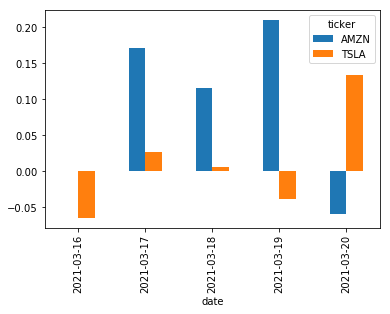

In [14]:
mean_df = mean_df.xs('compound', axis="columns").transpose()
mean_df.plot(kind='bar')
plt.show()

In [ ]:
####################################

In [ ]:
# Create the features set (X) and the target vector (y)
X = df_reviews["comment"].values
y = df_reviews["sentiment"].values

In [ ]:
# Create the train, test, and validation sets
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y)

X_train, X_val, y_train, y_val = train_test_split(X_train, y_train)

In [ ]:
# Import the libraries for sentiment scoring using Vader
import nltk
from nltk.sentiment.vader import SentimentIntensityAnalyzer

In [ ]:
# Download/Update the VADER Lexicon
nltk.download('vader_lexicon')

In [ ]:
# Initialize the VADER sentiment analyzer
analyzer = SentimentIntensityAnalyzer()

In [ ]:
# Define two lists to store vader sentiment scoring
y_vader_pred = []
y_vader_prob = []

In [ ]:
# Score sentiment of test set using Vader
for comment in X_test:
    y_vader_prob.append(analyzer.polarity_scores(comment)["pos"])
    sentiment_score = analyzer.polarity_scores(comment)["compound"]
    if sentiment_score >= 0.1:
        y_vader_pred.append(1)
    else:
        y_vader_pred.append(0)

In [ ]:
# Option 1: Normalizing data using MinMaxScaler from sklearn
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
scaler.fit(np.array(y_vader_prob).reshape(-1,1))
y_vader_prob_norm = scaler.transform(np.array(y_vader_prob).reshape(-1,1))
y_vader_prob_norm[:5]

In [ ]:
# Option 2: Using a comprehension list
normalized = [(x - min(y_vader_prob)) / (max(y_vader_prob) - min(y_vader_prob))
              for x in y_vader_prob]
normalized[:5]

In [ ]:
# Import the Tokenizer method from Keras
from tensorflow.keras.preprocessing.text import Tokenizer

In [ ]:
# Create an instance of the Tokenizer and fit it with the X text data
tokenizer = Tokenizer(lower=True)
tokenizer.fit_on_texts(X)

In [ ]:
# Print the first five elements of the encoded vocabulary
for token in list(tokenizer.word_index)[:5]:
    print(f"word: '{token}', token: {tokenizer.word_index[token]}")

In [ ]:
# Transform the text data to numerical sequences
X_seq = tokenizer.texts_to_sequences(X)

In [ ]:
# Contrast a sample numerical sequence with its text version
print("**Text comment**")
print({X[0]})

In [ ]:
print("**Numerical sequence representation**")
print(X_seq[0])